In [1]:
from climso.detection import Prominences, ProminenceSpeed

import os, re
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np


In [10]:
base_dir='Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/' #2023-07-28
files = [base_dir+file for file in os.listdir(base_dir) if file.startswith('imoa_06563_c1_')]

def extract_timestamp(file_path):
    match = re.search(r'\d{8}_\d{8}', file_path)
    if match:
        return match.group(0)
    return ''

files = sorted(files, key=extract_timestamp)
    
files

['Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07002976_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07052571_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07062581_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07072640_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07082463_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07092533_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07102513_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07112555_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07122567_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_07132525_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/20

In [9]:
files = files[-100:]

In [75]:
file =  'Y:/data/CLIMSO/2024/data_calibrated/2024-08-09/imoa_06563_c1_20240809_08174251_bri1.fts.bz2'

(-0.5, 499.5, -0.5, 499.5)

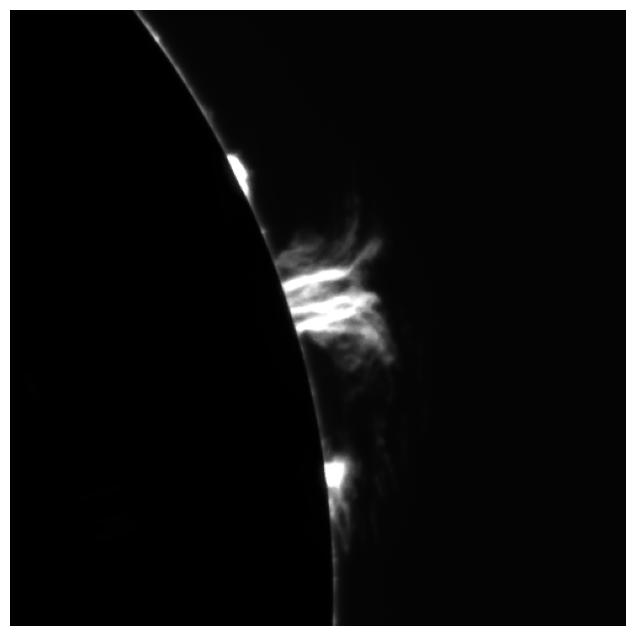

In [93]:
from astropy.io import fits

with fits.open(file) as hdul:
    data = np.flip(hdul[0].data, axis=0)

plt.figure(figsize=(8,8))
plt.imshow(data[1000:1500, 1540:2040], origin='lower', cmap='grey')

plt.axis('off')

In [4]:
images = []
for file in files:
    images.append(Prominences(file))

In [ ]:
# sort by date
images.sort(key=lambda x: x.date_obs)

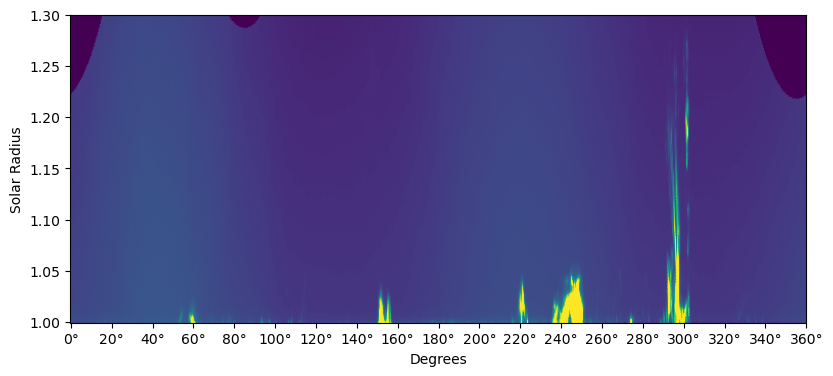

In [5]:
images[-1].plot()


In [6]:
images[-1].prominences

,deg,radius,value
0,152.0,1.033,16708.0
1,217.5,1.104,15008.0
2,246.0,1.058,15727.0
3,304.0,1.276,15049.0


In [7]:
base_prominence = images[-1].prominences.iloc[3]
last_deg = base_prominence.deg
date_rad = []
for n in range(2, len(images)):
    min_diff = np.inf
    closest_prom = None
    for idx, prominence in images[-n].prominences.iterrows():
        diff = abs(last_deg-prominence.deg)
        if diff<5 and diff<min_diff:
            min_diff=diff
            closest_prom=prominence
    if closest_prom is not None:
        last_deg = closest_prom.deg
        date_rad.insert(0,(images[-n].date_obs, closest_prom.radius))
        
date_rad.append((images[-1].date_obs, base_prominence.radius))

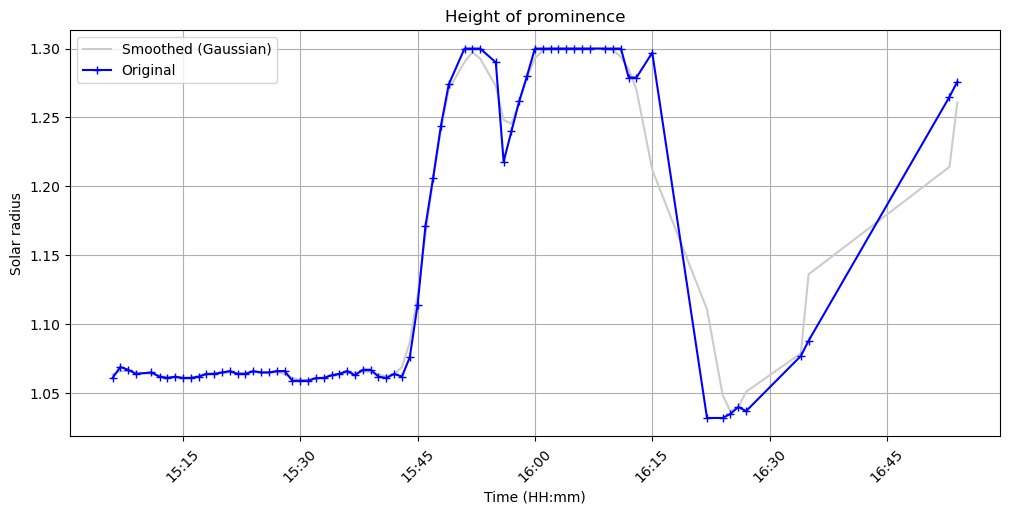

In [29]:
times = []
radiuses = []

for time, radius in date_rad:
    times.append(time)
    radiuses.append(radius)

smoothed_max_radiuses = gaussian_filter1d(radiuses, sigma=1, radius=5)

plt.figure(figsize=(10, 5))
plt.plot(times, smoothed_max_radiuses, marker='', linestyle='-', color='0.8', label='Smoothed (Gaussian)')
plt.plot(times, radiuses, marker='+', linestyle='-', color='b', label='Original')


plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

time_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(time_format)

plt.xlabel('Time (HH:mm)')
plt.ylabel('Solar radius')
plt.title('Height of prominence')
plt.legend();

In [30]:
len(times)

74

In [31]:
speeds = []
times = []
for n in range(1,len(date_rad)):
    distance = (date_rad[n][1] - date_rad[n-1][1])*696e3 # km
    time = abs(date_rad[n][0] - date_rad[n-1][0])
    if time.seconds == 0 : continue # to avoid division by zero
    
    speed = distance / time.seconds # km/s
    speeds.append(speed)
    times.append(date_rad[n][0])

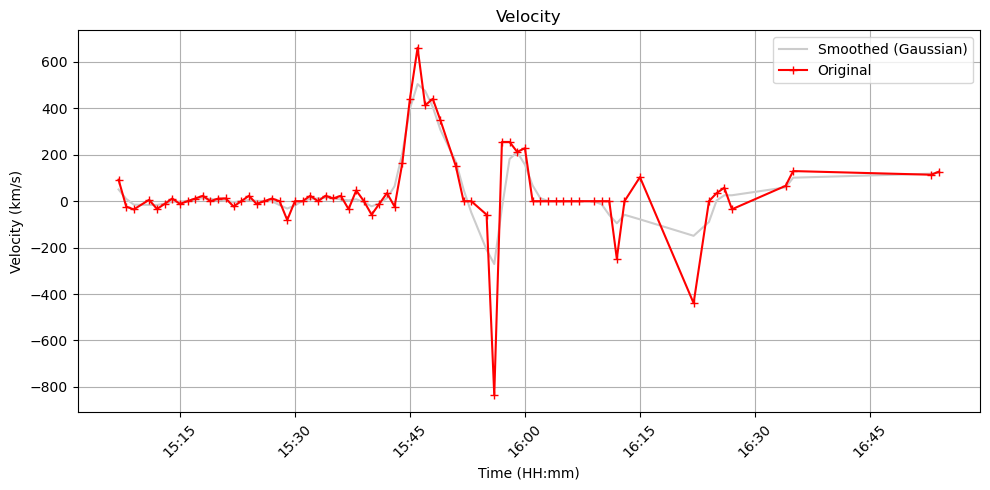

In [21]:
# Generate smoothed values
smoothed_values = gaussian_filter1d(speeds, sigma=1, radius=5)

# Plot the original and smoothed data
plt.figure(figsize=(10, 5))
plt.plot(times[-len(speeds):], smoothed_values, marker='', linestyle='-', color='0.8', label='Smoothed (Gaussian)')
plt.plot(times[-len(speeds):], speeds, marker='+', linestyle='-', color = 'r', label='Original')
plt.title('Velocity')
plt.xlabel('Time (HH:mm)')
plt.ylabel('Velocity (km/s)')
plt.grid(True)
plt.xticks(rotation=45)
time_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(time_format)
plt.tight_layout()
plt.legend();

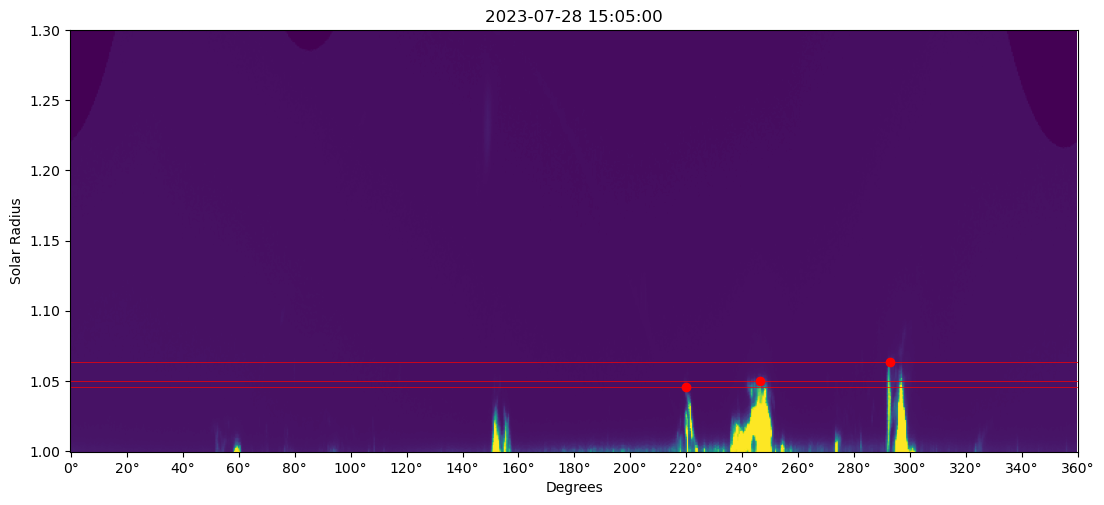

In [28]:
idx=0

fig, ax = plt.subplots(figsize=(13,6))
plt.imshow(images[idx].array, origin='lower')

for _, prom in images[idx].prominences.iterrows():
    plt.plot(int(prom.deg*2), int((prom.radius-1)*1e3), 'ro')
    plt.axhline(y=int((prom.radius-1)*1e3), color='red', linestyle='-', linewidth=0.5)

xticks = np.linspace(0, 360, 19)
ax.set_xticks(np.linspace(0, 720, 19))
ax.set_xticklabels([f'{xtick:.0f}°' for xtick in xticks])
plt.xlabel('Degrees')

yticks = np.linspace(1, 1+(len(images[idx].array)-1)*1e-3, 7)
ax.set_yticks(np.linspace(0, len(images[idx].array), 7))
ax.set_yticklabels([f'{ytick:.2f}' for ytick in yticks])

plt.ylabel('Solar Radius')

plt.title(images[idx].date_obs);

## Create GIF

In [14]:
import os
if not os.path.exists('frames'):
    os.makedirs('frames')
filenames = []
for idx, file in enumerate(images):
    
    fig, ax = plt.subplots(figsize=(13,6))
    plt.imshow(images[idx].array, origin='lower')

    for _, prom in images[idx].prominences.iterrows():
        plt.plot(int(prom.deg*2), int((prom.radius-1)*1e3), 'ro')
        plt.axhline(y=int((prom.radius-1)*1e3), color='red', linestyle='-', linewidth=0.5)


    xticks = np.linspace(0, 360, 19)
    ax.set_xticks(np.linspace(0, 720, 19))
    ax.set_xticklabels([f'{xtick:.0f}°' for xtick in xticks])
    plt.xlabel('Degrees')

    yticks = np.linspace(1, 1+(len(images[idx].array)-1)*1e-3, 7)
    ax.set_yticks(np.linspace(0, len(images[idx].array), 7))
    ax.set_yticklabels([f'{ytick:.2f}' for ytick in yticks])

    plt.ylabel('Solar Radius');
    
    plt.title(images[idx].date_obs);
    
    filename = f'frames/frame_{idx}.png'
    filenames.append(filename)
    plt.savefig(filename)
    plt.close()

In [15]:
import imageio

with imageio.get_writer('prominence.gif', mode='I', duration=0.1, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\lherrington\AppData\Local\Temp\ipykernel_2080\1843818749.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## final tests

In [26]:
images[-1].prominences

,deg,radius,value
0,152.0,1.033,16708.0
1,217.5,1.104,15008.0
2,246.0,1.058,15727.0
3,304.0,1.276,15049.0


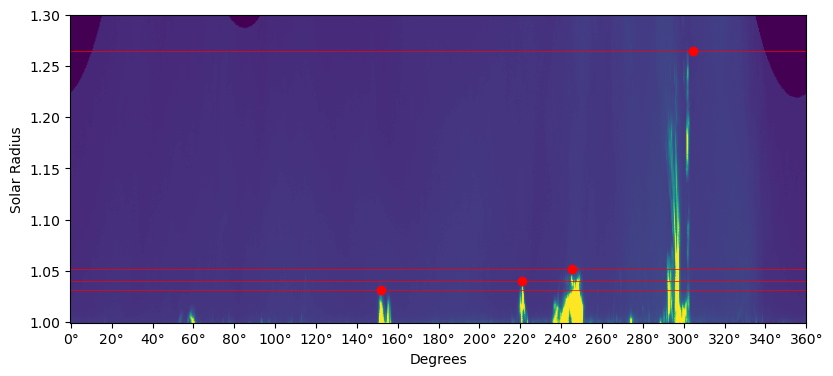

In [28]:
images[-2].plot()

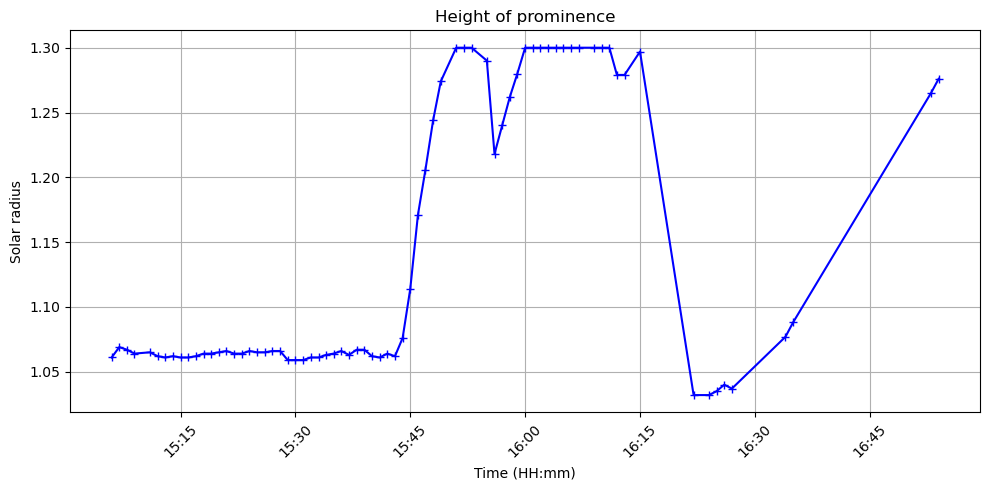

In [24]:
prom_speed = ProminenceSpeed(images, 3)

prom_speed.plotDistances()

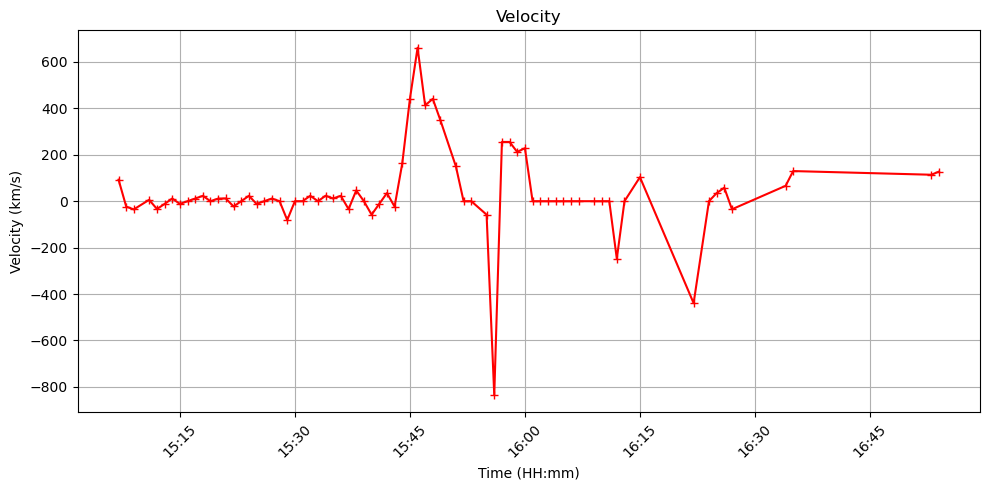

In [25]:
prom_speed.plotSpeed()